In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from evaluate import evaluate_holdout

In [2]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_droplet_size_data = pd.read_csv(f"{input_path}/scaled/droplet_size.csv")
encoded_droplet_size_data  = pd.read_csv(f"{input_path}/encoded/droplet_size.csv")
catboost_droplet_size_data = pd.read_csv(f"{input_path}/catboost/droplet_size.csv")

In [3]:
# Разделение признаков и целевой переменной
X_scaled = scaled_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_scaled = scaled_droplet_size_data["experiment.results.droplet_size.value"]

X_encoded  = encoded_droplet_size_data .drop(columns=["experiment.results.droplet_size.value"])
y_encoded  = encoded_droplet_size_data ["experiment.results.droplet_size.value"]

X_catboost = catboost_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_catboost = catboost_droplet_size_data["experiment.results.droplet_size.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

In [4]:
# Достаём scale и mean для обратного преобразования
df = pd.read_csv(f"{input_path}/scaled/full.csv")
column_name = "experiment.results.droplet_size.value"
column_index = df.columns.get_loc(column_name)

scaler = joblib.load(f"{input_path}/scaled/std_scaler.joblib")
scale = scaler.scale_[column_index]
mean = scaler.mean_[column_index]

In [5]:
# Разделение данных на тренеровочную и тестовую выборки
TEST_SIZE = 0.2

X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(
    X_scaled, y_scaled, test_size = TEST_SIZE, random_state = 0 
)

X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(
    X_encoded, y_encoded, test_size = TEST_SIZE, random_state = 0 
)

X_catboost_train, X_catboost_test, y_catboost_train, y_catboost_test = train_test_split(
    X_catboost, y_catboost, test_size = TEST_SIZE, random_state = 0 
)

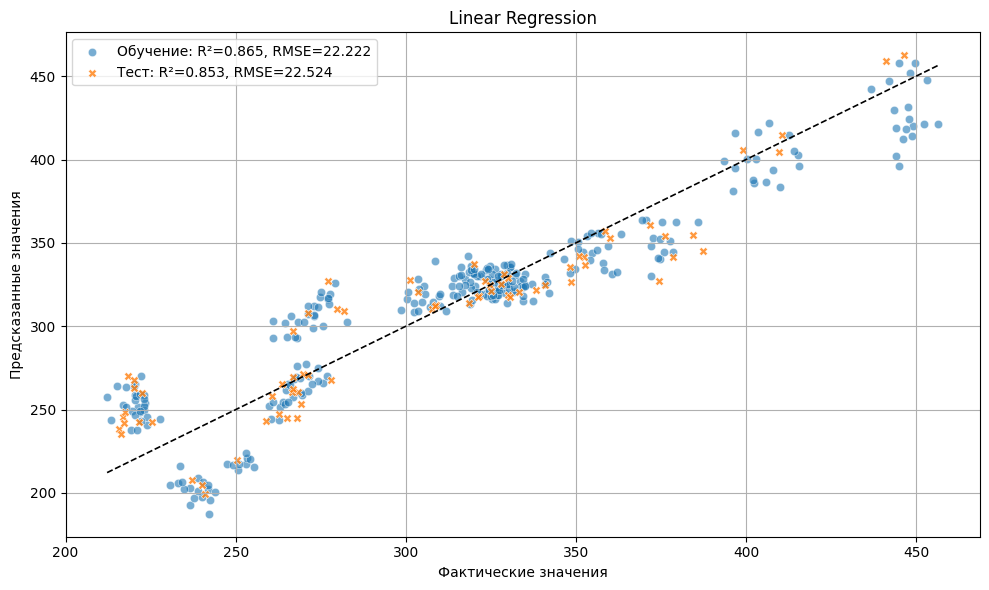

In [6]:
results["LinearRegression"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test, 
    LinearRegression(), "Linear Regression",
    scale=scale, mean=mean
)

In [7]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 3, 6),        # 0.01, 0.1, 1, 10, 100, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=3)
grid_search.fit(X_scaled_train, y_scaled_train)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': np.float64(10.0), 'epsilon': np.float64(0.01), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9800747517013816


In [8]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(0, 2, 40),        
    'epsilon': np.logspace(-3, -1, 40),
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled_train, y_scaled_train)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
Best parameters: {'C': np.float64(17.012542798525892), 'epsilon': np.float64(0.03888155180308087), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9802733006478658


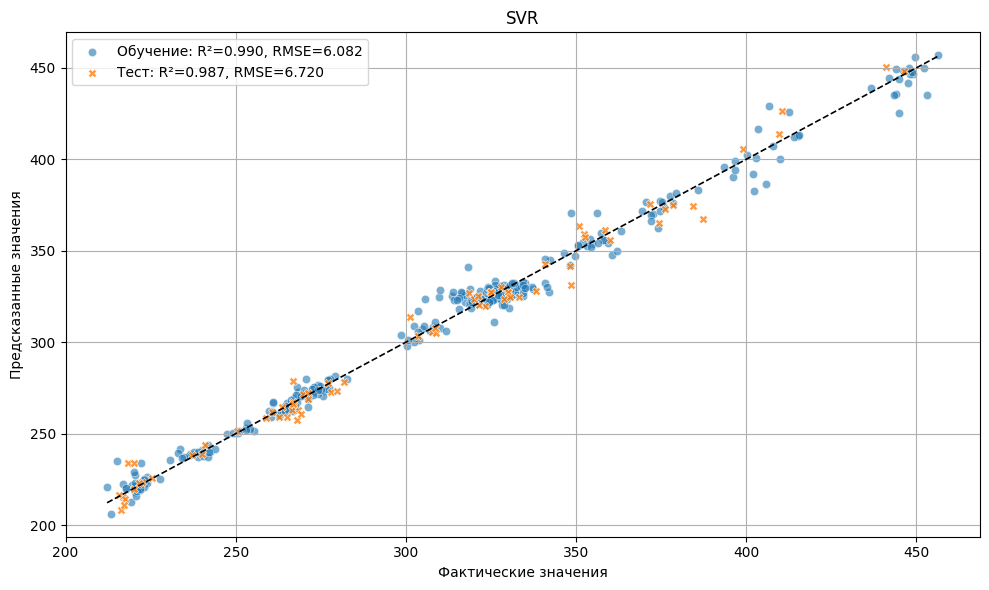

In [9]:
results["SVR"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test,
    SVR(**grid_search.best_params_), "SVR",
    scale=scale, mean=mean
)

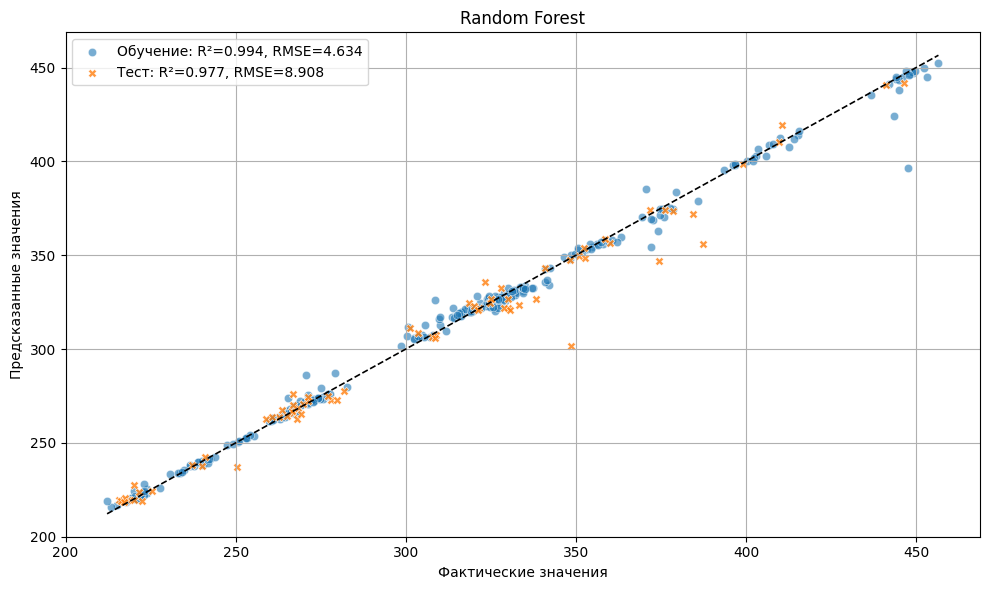

In [10]:
results["RandomForest"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    RandomForestRegressor(), "Random Forest"
)

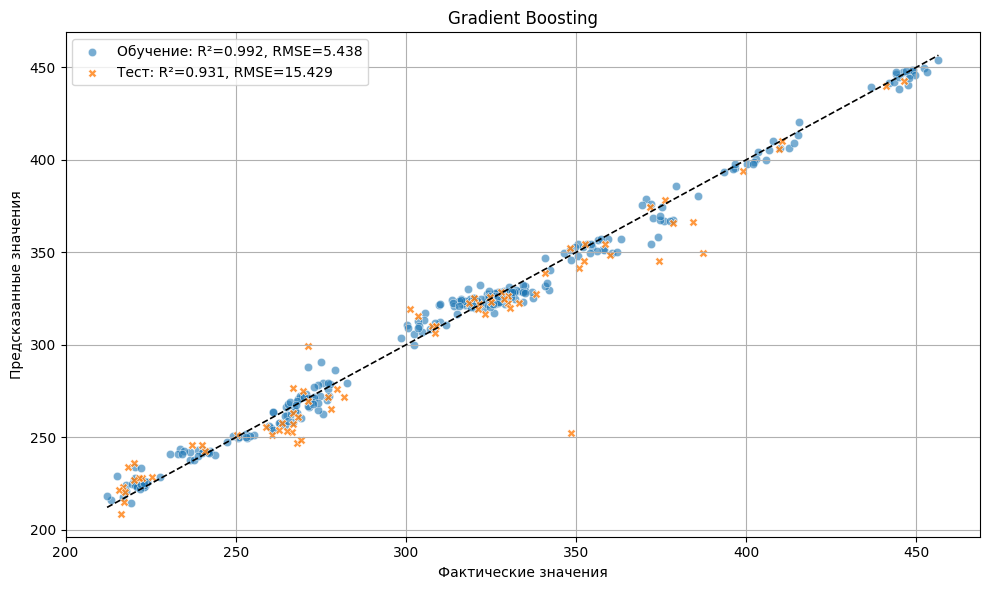

In [11]:
results["GradientBoosting"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    GradientBoostingRegressor(), "Gradient Boosting"
)

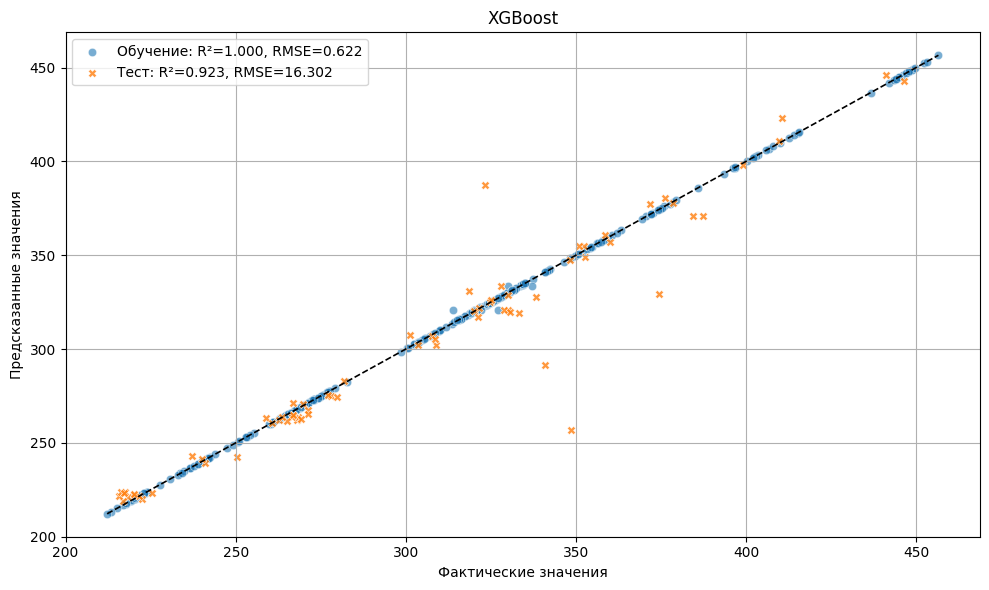

In [12]:
results["XGBoost"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(), "XGBoost"
)

In [13]:
# Параметры для подбора XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Continuous(0.01, 0.3),
    'subsample': Continuous(0.5, 1.0),
    'colsample_bytree': Continuous(0.5, 1.0),
    'gamma': Continuous(0, 5),
    'reg_alpha': Continuous(0, 2),
    'reg_lambda': Continuous(0, 2),
}

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Генетический поиск
evolved_search = GASearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='auto', random_state=0),
    cv=cv,
    scoring='r2',
    param_grid=param_grid,
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    error_score='raise'
)

# Обучение
evolved_search.fit(X_encoded_train, y_encoded_train)

# Лучшие параметры
print("Best parameters:", evolved_search.best_params_)
print("Best R2 score (CV):", evolved_search.best_score_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.914971	0.0372356  	0.94407    	0.758278   
1  	60    	0.93668 	0.00634137 	0.944323   	0.926087   
2  	60    	0.941633	0.0035992  	0.944942   	0.932164   
3  	60    	0.944242	0.00157269 	0.947284   	0.939343   
4  	60    	0.945383	0.00266515 	0.949437   	0.937214   
5  	60    	0.947182	0.00256211 	0.951749   	0.93815    
6  	60    	0.94877 	0.00199516 	0.951749   	0.943078   
7  	60    	0.950079	0.00163952 	0.95249    	0.945631   
8  	60    	0.951205	0.00133252 	0.954613   	0.947579   
9  	60    	0.95162 	0.00103922 	0.95435    	0.949171   
10 	60    	0.951476	0.0022983  	0.95435    	0.940236   
11 	60    	0.952754	0.00228293 	0.959065   	0.944038   
12 	60    	0.953473	0.00171864 	0.959065   	0.948747   
13 	60    	0.954534	0.00198533 	0.959196   	0.951478   
14 	60    	0.955742	0.00300819 	0.959671   	0.948164   
15 	60    	0.957117	0.00248761 	0.959671   	0.949487   
16 	60    	0.957809	0.00308046 	0.963349   	0.95

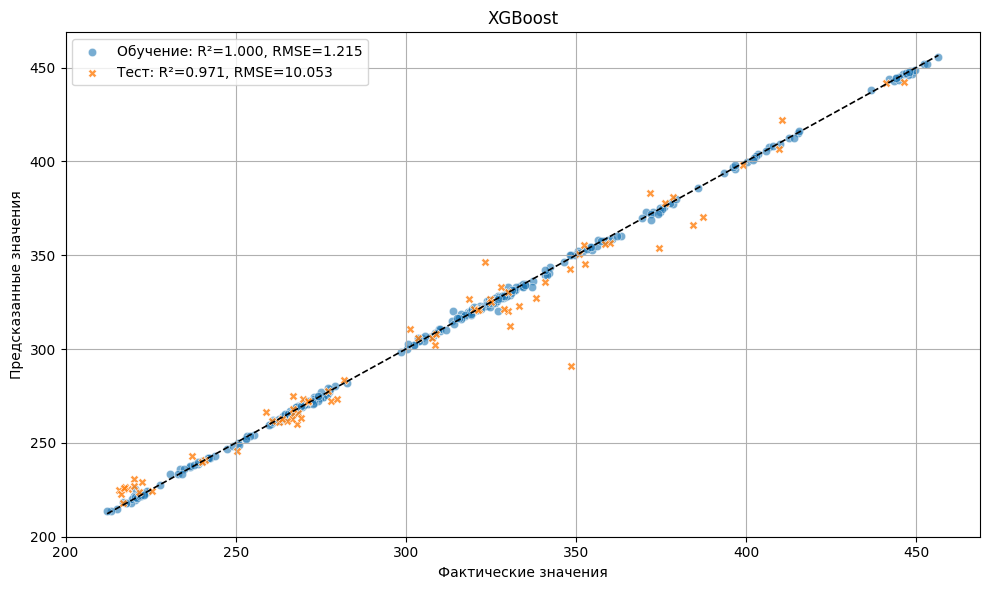

In [14]:
results["XGBoost"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(**evolved_search.best_params_), "XGBoost"
)

Learning rate set to 0.033633
0:	learn: 59.1137584	total: 172ms	remaining: 2m 51s
1:	learn: 57.8870856	total: 221ms	remaining: 1m 50s
2:	learn: 56.5705001	total: 270ms	remaining: 1m 29s
3:	learn: 55.4038396	total: 350ms	remaining: 1m 27s
4:	learn: 54.2097950	total: 456ms	remaining: 1m 30s
5:	learn: 53.0274908	total: 484ms	remaining: 1m 20s
6:	learn: 51.9309727	total: 580ms	remaining: 1m 22s
7:	learn: 51.0175105	total: 629ms	remaining: 1m 18s
8:	learn: 49.9134991	total: 726ms	remaining: 1m 19s
9:	learn: 48.9183722	total: 809ms	remaining: 1m 20s
10:	learn: 48.2073797	total: 903ms	remaining: 1m 21s
11:	learn: 47.2923165	total: 956ms	remaining: 1m 18s
12:	learn: 46.4089499	total: 995ms	remaining: 1m 15s
13:	learn: 45.5165765	total: 1.04s	remaining: 1m 13s
14:	learn: 44.6614281	total: 1.08s	remaining: 1m 11s
15:	learn: 44.0142746	total: 1.13s	remaining: 1m 9s
16:	learn: 43.3755499	total: 1.18s	remaining: 1m 8s
17:	learn: 42.7505822	total: 1.22s	remaining: 1m 6s
18:	learn: 42.0466064	total: 

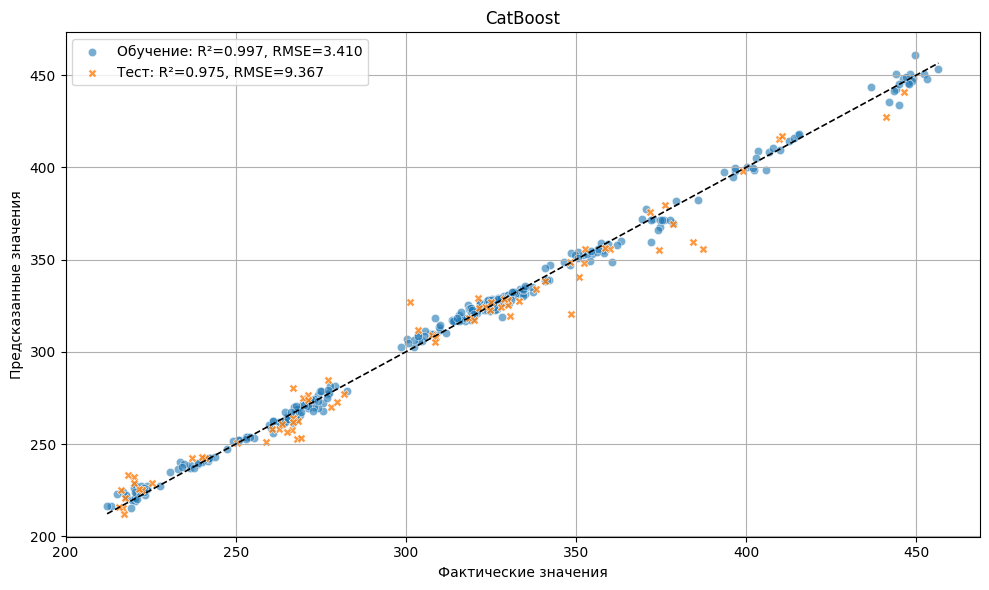

In [15]:
results["CatBoost"] = evaluate_holdout(
    X_catboost_train, X_catboost_test,
    y_catboost_train, y_catboost_test, 
    CatBoostRegressor(), "CatBoost",
    cat_features=catboost_features
)

In [16]:
results_df = pd.DataFrame(results)
results_df = results_df.T.reset_index().rename(columns={'index': 'Модель'})
results_df = results_df.sort_values("r2_test", ascending=False).reset_index(drop=True)
results_df = results_df.rename(columns={
    "model":      "Модель",
    "r2_train":   "R² обуч.",
    "rmse_train": "RMSE обуч.",
    "r2_test":    "R² тест.",
    "rmse_test":  "RMSE тест."
})

results_df

,Модель,R² обуч.,RMSE обуч.,R² тест.,RMSE тест.
0,SVR,0.989895,6.081541,0.986923,6.719734
1,RandomForest,0.994133,4.633962,0.977019,8.907997
2,CatBoost,0.996822,3.410447,0.974588,9.367232
3,XGBoost,0.999596,1.215277,0.970734,10.052552
4,GradientBoosting,0.991920,5.438013,0.931059,15.428785
5,LinearRegression,0.865076,22.222023,0.853068,22.524294
